### Vector hóa để tăng tốc độ tính toán
- Khi huấn luyện mô hình, ta thường muốn xử lý đồng thời các mẫu dữ liệu trong minibatch. Để làm được điều này, ta cần phải vector hóa việc tính toán bằng cách sử dụng các thư viện đại số tuyến tính thay vì sử dụng các vòng lặp for trong python.
- Chúng ta sẽ sử dụng hai phương pháp cộng vector dưới đây để thấy được tại sao vector hóa là cần thiết trong học máy.
- Đầu tiên, khởi tạo hai vector 10000 chiều chứa toàn giá trị 1
- Ta sẽ sử dụng vòng lặp for trong python ở phương pháp thứ nhất và một hàm trong thư viện np ở phương pháp thứ hai.
- Ta sẽ định nghĩa bộ đánh giá thời gian (có thể truy cập thông qua gói d2l)

In [258]:
%matplotlib inline
from d2l import mxnet as d2l
import math
from mxnet import np
import time

n = 10000
a = np.ones(n)
b = np.ones(n)

class Timer(object):
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()
    
    def start(self):
        self.start_time = time.time()

    def stop(self):
        self.times.append(time.time() - self.start_time)
        return self.times[-1]
    
    def avg(self):
        return sum(self.times) / len(self.times)
    
    def sum(self):
        return sum(self.times)
    
    def cumsum(self):
        return np.array(self.times).cumsum().tolist()
    

Đầu tiên, ta sử dụng vòng for để cộng các tọa độ tương ứng

In [259]:
timer = Timer()
c = np.zeros(n)
for i in range(n):
    c[i] = a[i] + b[i]

'%.5f sec' % timer.stop()

'2.34773 sec'

Phương pháp thứ hai, ta dựa vào thư viện np để tính tổng hai vector theo từng phần tử:

In [260]:
timer.start()
d = a + b
'%.5f sec' % timer.stop()

'0.00053 sec'

### Phân phối chuẩn và hàm mất mát bình phương
- Ta sẽ làm rõ hơn nguồn gốc của hàm mất mát bình phương thông qua các giả đinh về phân phối của nhiễu.
- Phân phối chuẩn (gauss):
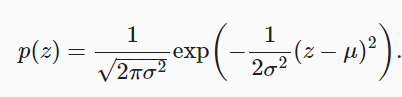

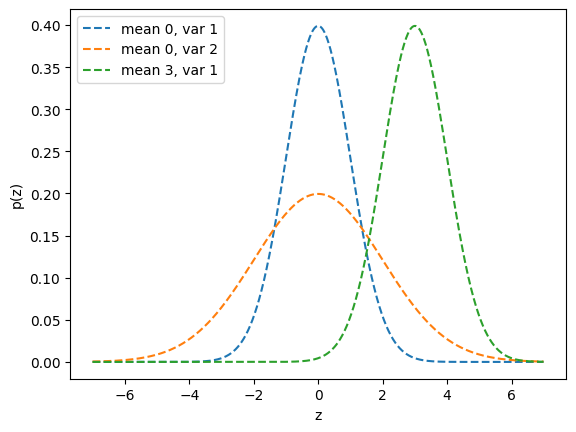

In [261]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(-7, 7, 0.01)

def normal(z, mu, sigma):
    p = 1 / np.sqrt(2 * np.pi * sigma**2)  # Sử dụng numpy.sqrt
    return p * np.exp(-0.5 / sigma**2 * (z - mu)**2)

# Mean and variance pairs
parameters = [(0, 1), (0, 2), (3, 1)]

# Vẽ đồ thị
for mu, sigma in parameters:
    plt.plot(x, normal(x, mu, sigma), label=f'mean {mu}, var {sigma}', linestyle = '--')
    
plt.xlabel('z')
plt.ylabel('p(z)')
plt.legend()
plt.show()


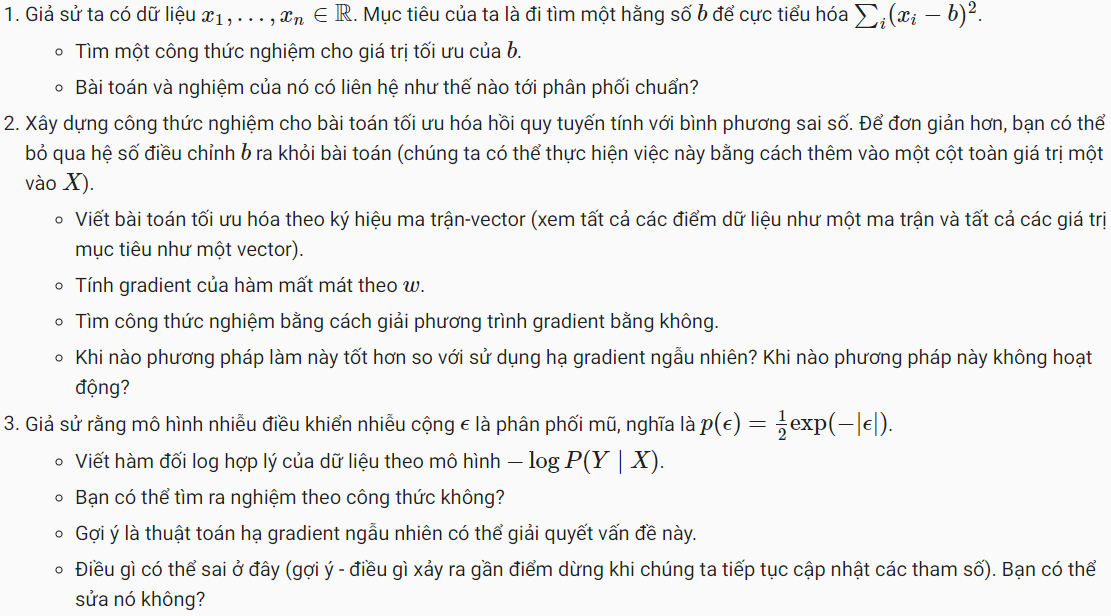

### Lập trình hồi quy tuyến tính từ đầu
Ta bắt đầu viết mã, trong phần này, ta sẽ xây dựng toàn bộ kỹ thuật này từ đầu, bao gồm: Pipeline dữ liệu, mô hình, hàm loss và phương pháp tối ưu hạ gradient. 
Ta sẽ chỉ dựa vào ndarray và autograd.

In [262]:
from d2l import mxnet as d2l
from mxnet import autograd, np, npx
import random
npx.set_np()

#### Tạo tập dữ liệu
- Ta sẽ xây dựng một tập dữ liệu nhân tạo theo mô hình tuyến tính với nhiễu cộng. Nhiệm vụ của chúng ta là khôi phục các tham số của mô hình bằng cách sử dụng một tập hợp hữu hạn các mẫu có trong tập diwx liệu. CHúng ta sẽ sử dụng dữ liệu chứa 1000 mẫu, mỗi mẫu bao gồm hai đặc trưng được lấy ngẫu nhiên theo phân phối chuẩn. -> tập dữ liệu có chiều 1000 x 2.

Các tham số đúng để tạo tập dữ liệu sẽ là w = (2, -3.4)^T và b = 4.2 sẽ tạo ra dựa theo mô hình tuyến tính với nhiễu epsilon tuân theo phân phối chuẩn với trung bình bằng 0 và độ lệch bằng 1

In [263]:
def synthetic_data(w, b, num_examples):
    """Generate y = w * x + b + noise"""
    x = np.random.normal(0, 1, size = (num_examples, len(w)))
    y = np.dot(x, w) 
    y += b + np.random.normal(0, 0.01, size = y.shape)

    return x, y

true_w = np.array([2, 3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

features[:10], labels[:10]
# features.shape, labels.shape

(array([[ 1.2330939 , -0.52515286],
        [-0.6492431 , -0.6359127 ],
        [-0.68682927,  1.4622228 ],
        [-0.8038175 ,  1.1285355 ],
        [ 0.27026308, -0.18499799],
        [-2.0224795 ,  0.92705315],
        [ 1.0066068 ,  0.20604515],
        [ 0.1028611 ,  0.01542763],
        [ 0.31575608,  1.4400473 ],
        [ 0.25776315,  1.3831338 ]]),
 array([4.869375 , 0.7563398, 7.7784967, 6.425984 , 4.103568 , 3.3073273,
        6.9275265, 4.441274 , 9.723154 , 9.401506 ]))

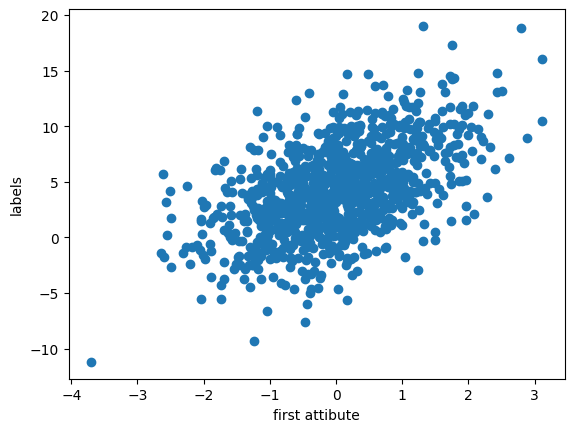

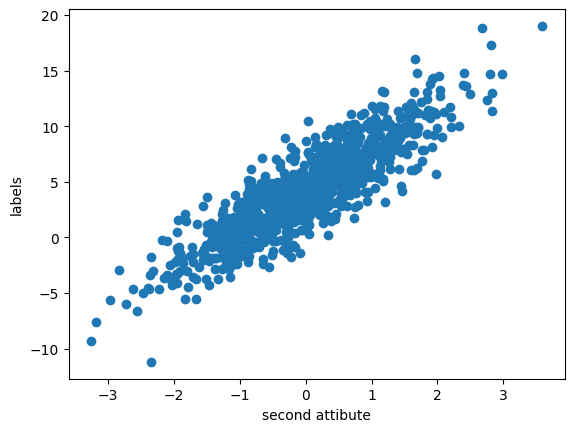

In [264]:
plt.scatter(features[:, 0], labels)
plt.xlabel(xlabel='first attibute')
plt.ylabel(ylabel='labels')
plt.show()
plt.scatter(features[:, 1], labels)
plt.xlabel(xlabel='second attibute')
plt.ylabel(ylabel='labels')
plt.show()

#### Đọc từ tập dữ liệu
Việc huấn luyện mô hình bao gồm tách tập dữ liệu thành nhiều phần (Các minibatch), lần lượt đọc từng phần của tập dữ liệu mẫu và sử dụng chúng để cập nhật mô hình. Vì quá trình này rất căn bản để huấn luyện các giải thuật học máy, ta nên định nghĩa một hàm để trộn và truy xuất dữ liệu trong các minibatch một cách tiện lợi.

In [265]:
def data_iter(batch_size, features, labels):
    num_examples = len(features) # Xác định tổng số dữ liệu mẫu trong features
    indices = list(range(num_examples)) # Tạo một danh sách các chỉ số 0 -> num_examples - 1

    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size): # Lặp qia toàn bộ dữu liệu theo từng đoạn, mỗi đoạn có kích thước bằng batch_size
        # Chỉ số i đại diện cho điểm bắt đầu của mỗi lô trong tập dữ liệu

        # Tạo một mảng chỉ số cho các mẫu thuộc lô hiện tại
        batch_indices = np.array(indices[i:min(i + batch_size, num_examples)])

        # Trả về (không phải return) một cặp (features, labels) tương ứng với các chỉ số trong batch_indices
        # Việc sử dụng yield cho phép hàm hoạt động như một generator, tiết kiệm bộ nhớ do chỉ tải từng lô thay vì toàn bộ dữ liệu
        yield features[batch_indices], labels[batch_indices]


In [266]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, "\n", y)
    break

[[ 0.31575608  1.4400473 ]
 [-0.8236109  -0.4722432 ]
 [ 0.52956563  0.68217033]
 [-0.16978693  0.26689255]
 [-1.8974041  -0.2941085 ]
 [-0.66615075 -0.65146   ]
 [ 0.48807895  2.7931957 ]
 [ 0.70637196  0.15344548]
 [-0.9101806   0.09497186]
 [ 0.03310335 -0.9723959 ]] 
 [ 9.723154    0.95472765  7.587278    4.7638216  -0.58929586  0.6427622
 14.6705065   6.1451464   2.703517    0.9590442 ]


#### Khởi tạo các tham số mô hình
- Để tối ưu các tham số của dữ liệu bằng hạ gradient, đầu tiên ta cần khởi tạp chúng, trong đoạn mã dưới đây, ta khởi tạo các trọng số bằng cách lấy ngẫu nhiên các mẫu từ một phân phối chuẩn có giá trị trunbg bình bằng 0 và độ lệch chuẩn là 0,01 sau đó gán hệ số điều chỉnh b bằng 0.

In [267]:
w = np.random.normal(0, 0.01, (2, 1))
w = np.zeros(shape = (2, 1))
b = np.zeros(1)

w.attach_grad()
b.attach_grad()

#### Định nghĩa mô hình
Ta cần định nghĩa mô hình dựa trên đầu vào và tham số liên quan tới đầu ra. Nhắc lại rằng để tính đầu ra cuarm ột mô hình tuyến tính, ta có thể down giản tính tích vô hướng ma trận vector của các mẫu X và trọng số mô hình w sau đó thêm vào hệ số điều chỉnh b cho từng mẫu. 

In [268]:
def linreg(X, w, b):
    return np.dot(X, w) + b

#### Định nghĩa hàm los
Để cập nhật mô hình ta cần tính gradient của hàm mất mát. Ta sẽ sử dụng hàm mất mát bình phương. Trên thực tế ta cần chuyển đổi giá trị nhãn thật y sang kích thước của giá trị dự đoán y_hat.

In [269]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape))** 2 / 2

for X, y in data_iter(batch_size, features, labels):
    # print(X, "\n", y)
    print(squared_loss(y, linreg(X, w, b)))
    break

[1.80799576e+02 1.24553204e+00 1.30126968e-01 1.07377533e+02
 5.50804482e+01 1.20443535e+01 7.54158354e+00 3.29031792e+01
 1.13647568e+00 9.69282329e-01]


#### Định nghĩa thuật toán tối ưu
- Sử dụng hạ gradient ngẫu nhiên (stochastic gradient descent - SGD)
- Sử dụng một batch được lấy ngẫu nhiên từ tập dữ liệu tại mỗi bước, ta sẽ ước tính được gradient của hàm mất mát theo các tham số, tiếp đó ta sẽ cập nhật các tham số vói một lượng nhỏ theo chiều làm giảm của sự mất mát. 
- Kích thước của bước cập nhật được xác định bởi tốc độ học lr. Bởi vì các mất mát được tính dựa trên tổng của các mẫu của batch, ta chuẩn hóa kích thước cập nhật theo kích thước batch sao cho độ lớn của mỗi bước cập nhật không phụ thuộc nhiều vào kích thước batch.

In [270]:
def sgd(params, lr, batch_size):
    for param in params:
        # Sử dụng param[:] là để giá trị cập nhật sẽ được thay đổi ngay tại param chứ không tạo ra thêm đối tượng mới
        # Nếu sử dụng param = thì sẽ tạo ra đối tượng mới dẫn đến các đối tượng trong mô hình không được cập nhật
        param[:] = param - lr * param.grad / batch_size

#### Huấn luyện
- Trong mỗi vòng lặp, đầu tiên ta sẽ lấy ra các minibatch dữ liệu và chạy nó qua mô hình để lấy ra tập kết quả dự đoán, sau khi tính toán sự mất mát, ta dùng hàm backward để lan truyền ngược qua mạng, lưu trữ các gradient tương ứng với mỗi tham số trong từng thuộc tính .grad tương ứng, cuối cùng, ta sử dụng thuật toán tối ưu sgd để cập nhật các tham số của mô hình. 

In [271]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        with autograd.record():
            y_pred = net(X, w, b)
            current_loss = loss(y, y_pred)
        current_loss.backward()

        sgd([w, b], lr, batch_size)

    print(f"epoch: {epoch}, loss = {current_loss.sum()}")

epoch: 0, loss = 0.18557584
epoch: 1, loss = 0.00023943887
epoch: 2, loss = 0.00028581722


In [272]:
print(f"true_W = {true_w} and true_b = {true_b}")
print(f"model's weight = {w.reshape(true_w.shape)}, b = {b[-1]}")

true_W = [2.  3.4] and true_b = 4.2
model's weight = [1.9995887 3.3998342], b = 4.1993065


In [273]:

### Lập trình súc tích hồi quy tuyến tính bằng Gluon
#### Tạo tập dữ liệu

In [274]:
from d2l import mxnet as d2l
from mxnet import autograd, np, npx, gluon

npx.set_np()
true_w = np.array([2, -3.4])
true_b = 4.2

# Tạo tập dữ liệu nhân tạo
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

# Đọc tập dữ liệu
def load_array(data_array, batch_size, is_train = True):
    """Construct a Gluon data loader"""
    dataset = gluon.data.ArrayDataset(*data_array)
    return gluon.data.DataLoader(dataset, batch_size, shuffle = is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

for X, y in data_iter:
    print(X, "\n", y)
    break

[[ 0.72529763  0.12528373]
 [ 0.4112578   0.44640878]
 [ 1.7767802   1.2435915 ]
 [-0.6357538  -0.25183243]
 [-0.83742946 -0.7069889 ]
 [-1.6161643  -0.4049605 ]
 [-0.24742486  1.6705337 ]
 [-1.4359633   0.678974  ]
 [-0.10351865 -0.86956793]
 [-0.47549707 -1.6268587 ]] 
 [[ 5.2311087 ]
 [ 3.5161088 ]
 [ 3.5127501 ]
 [ 3.7920012 ]
 [ 4.930329  ]
 [ 2.3355346 ]
 [-1.9573636 ]
 [-0.97542834]
 [ 6.9375577 ]
 [ 8.780303  ]]


Đối với những tác vụ tiêu chuẩn, chúng ta có thể sử dụng các tầng đã được định trước trong Gluon, điều này cho phép chúng ta tập trung vào những tầng được dùng để xây dựng mô hình hơn là cách lập trình các tầng đó. Để định nghĩa một mô hình tuyến tính, đầu tiên chúng ta cần nhập vào module nn, giúp ta định nghĩa một lượng lớn các tầng trong mạng neural. Đầu tiên ta định nghĩa mootju biến mô hình là net, tham chiếu đến một thực thể của lớp Sequential.
Trong Gluon, Sequential sẽ truyền dữ liệu vào tầng đầu tiên, kết quả đầu ra từ đó trở thành đầu vào của tầng thứ hai và cứ tiếp tục như thế đến các tầng kế tiếp.
Trong ví dụ này, mô hình của chúng ta chỉ có duy nhất một tầng, nên không nhất thiết phải sử dụng Sequential. Tuy nhiên vì hầu hết các mô hình ta gặp phải trong tương lai đều có nhiều tầng nên dùng để làm quen với quy trình làm việc tiêu chuẩn nhất.

In [275]:
from mxnet.gluon import nn
net = nn.Sequential()

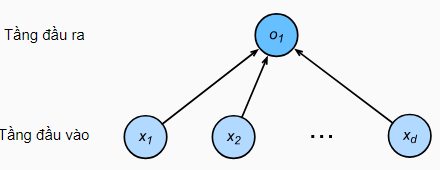

Hồi quy tuyến tính là một mạng neural đơn tầng và có kết nối đầy đủ.
Trong Gluon, tầng kết nối đầy đủ được định nghĩa trong lớp Dense. Vì ta chỉ cần xuất ra một số vô hướng duy nhất nên ta gán giá trị là 1.

In [276]:
net.add(nn.Dense(1))

Để thuận tiện, điều đáng chú ý là Gluon không yêu cầu chúng ta chỉ định kích thước đầu vào mỗi tầng. Nên tại đây, chúng ta không cần thiết cho Gluon biết có bao nhiêu đầu vào cho mỗi tầng tuyến tính. 

#### Khởi tạo tham số cho mô hình
- Trước khi sử dụng net, chúng ta cần phả khởi tạo tham số cho mô hình, chẳng hạn như trọng số và hệ số điều chỉnh trong mô hình hồi quy tuyến tính. CHúng ta sẽ nhập module initialize từ MXNet.
- Module này cung cấp nhiều phương thức khác nhau để khởi tạo tham số cho mô hình. Bằng cách gọi init.Normal(sigma = 0.01) chúng ta sẽ khởi tạo ngẫu nhiên các trọng số từ một phân phối chuẩn với trung bình bằng 0 và độ lệch chuẩn bằng 0.01. 
- Mặc định, tham số hệ số điều chỉnh sẽ được khởi tạo bằng 0, cả hai vector trọng số và hệ số điều chỉnh sẽ có gradient kèm theo.

In [277]:
from mxnet import init
net.initialize(init.Normal(sigma = 0.01))

Đoạn mã trông khá đơn giản nhưng ta đã khởi tạo tham số cho một mạng trong khi Gluon chưa hề biết số chiều của đầu vào là bao nhiêu. Quá trình khởi tạo hiện tại vẫn đang bị trì hoãn và chỉ bắt đầu khi ta truyền dữ liệu vào mạng lần đầu tiên.

#### Định nghĩa hàm mất mát
Trong Gluon, module loss định nghĩa các hàm mất mát khác nhau. Chúng ta sẽ sử dụng modile loss thêm vào dưới tên gọi là gloss và triển khai mất mát bình phương L2Loss

In [278]:
from mxnet.gluon import loss as gloss
loss = gloss.L2Loss() 

#### Định nghĩa thuật toán tối ưu
- Minibatch SGD và các biến thể liên quan đều là các công cụ chuẩn cho việc tối ưu hóa mạng neural nên Gluon có hỗ trợ SGD cùng với một số biến thể của thuật toán này thông qua lớp Trainer.
- khi khởi tạo lớp trainer, ta chỉ cần chỉ định các tham số để tối ưu hóa, có thể lấy từ mạng thông qua net.collect_params(). 
- Thuật toán tối ưu muốn sử dụng sgd và một từ điển gồm các siêu tham số cần thiết cho thuật toán tối ưu. SGD chỉ yêu cầu giá trị của learning_rate.

In [279]:
from mxnet import gluon
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.03})

#### Huấn luyện
- Việc biểu diễn mô hình thông qua Gluon đòi hỏi tương đối ít dòng lệnh, ta không cần phải khởi tạo từng tham số riêng lẻ, định nghĩa hàm mất mát hay lập trình thuật toán hạ gradient ngẫu nhiên SGD. 
- Tuy nhiên, khi ta có các mảnh ghép cơ bản thì việc huấn luyện lại giống với những gì ta đã làm khi lập trình lại mọi thứ từ đầu.
-  Với mỗi minibatch, ta cần tuân thủ theo trình tự sau:
    1. Đưa ra dự đoán bằng cách gọi net(X) và tính giá trị mất mát l (lượt truyền xuôi)
    2. Tính gradient bằng cách gọi l.backward() (lượt truyền ngược)
    3. Cập nhật các tham số của mô hình bằng cách gọi bộ tối ưu SGD (chú ý rằng trainer đã biết các tham số cần tối ưu nên ta chỉ cần truyền thêm kích thước của minibatch)

In [287]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        with autograd.record():
            y_pred = net(X)
            l = loss(y_pred, y)
        l.backward()
        trainer.step(batch_size)
    l = loss(net(features), labels)
    print(f"epoch: {epoch}, loss = {l.mean()}, {net[0].weight.grad}")

epoch: 0, loss = 4.8864327e-05, <bound method Parameter.grad of Parameter dense1_weight (shape=(1, 2), dtype=float32)>
epoch: 1, loss = 4.895408e-05, <bound method Parameter.grad of Parameter dense1_weight (shape=(1, 2), dtype=float32)>
epoch: 2, loss = 4.9041046e-05, <bound method Parameter.grad of Parameter dense1_weight (shape=(1, 2), dtype=float32)>


In [282]:
w = net[0].weight.data()
print("weigth of nn: ", w)
print("true weight: ", w)

n = net[0].bias.data()
print("bias of nn: ", b)
print("true bias: ", true_b)


weigth of nn:  [[ 1.9997642 -3.3993251]]
true weight:  [[ 1.9997642 -3.3993251]]
bias of nn:  [4.1993065]
true bias:  4.2


#### Bài tập
1. Nếu thay thế l = loss(output, y) bằng l = loss(output, y).mean(), chúng ta cần đổi trainer.step(batch_size) thành trainer.step(1) để phần mã nguồn này hoạt động giống như trước. Tại sao lại thế?
- Trong quá trình huấn luyện, thay tính toán gradient của một vector đối với từng tham số thì ta tính gradient của hàm vector.sum() là một hàm vô hướng. cụ thể ở đây là tính gradient của hàm sum(l) với từng tham số.
- Sau khi tính toán gradient với từng tham số thì ta sẽ cộng tất cả chúng lại và chia cho batch_size. Tuy nhiên, do hàm l đã chia cho batch_size trước đó nên khi sử dụng trainer thì ta chỉ cần để batch_size của trainer là 1.